# Sentiment Analysis

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# 1. Charger les données
df = pd.read_csv("C:/Users/arist/Downloads/archive/YoutubeCommentsDataSet.csv")  

df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [2]:
df.shape

(18408, 2)

We can see that they are 18000 comments

In [3]:
df.isnull().sum()

Comment      44
Sentiment     0
dtype: int64

In [4]:
df=df.dropna()

We delete the lines that are empty

In [5]:
print(df["Comment"][3])

whenever i go to a place that doesn’t take apple pay doesn’t happen too often it’s such a drag between ‘contactless covid’ habits and my getting the apple card i’ve gotten so used to apple pay that i get seriously annoyed when a store doesn’t take it it feels like a shock it’s crazy how quickly it took over my shopping routine i’ve officially been brainwashed by apple because now it feels so inconvenient to even carry a physical card in my pocket


In [6]:
df['Sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

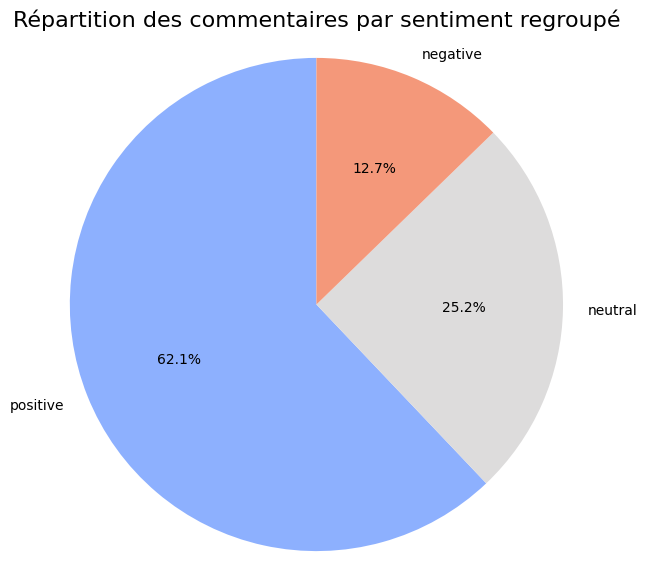

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_counts = df['Sentiment'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('coolwarm', 3))
plt.title("Répartition des commentaires par sentiment regroupé", fontsize=16)
plt.axis('equal')
plt.show()


We can see their a huge imbalence in the dataset

In [55]:
!pip install emoji

   ---------------------------------------- 0.0/608.4 kB ? eta -:--:--
   --------------------------------------- 608.4/608.4 kB 11.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import emoji

# --- Préparatifs NLTK ---
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# --- Pipeline de nettoyage simplifié ---
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # supprimer URLs
    text = re.sub(r'@\w+', '', text)                     # supprimer mentions
    text = re.sub(r'#', '', text)                        # retirer # mais garder le mot
    text = re.sub(r'\d+', '', text)                      # supprimer chiffres
    text = re.sub(r'[^\w\s]', '', text)                 # retirer ponctuation
    text = emoji.demojize(text)                          # transformer emojis en texte
    text = re.sub(r'\s+', ' ', text).strip()            # supprimer espaces multiples
    # Supprimer stopwords et lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# --- Appliquer le preprocessing ---
df['cleaned_text'] = df['Comment'].apply(clean_text)

label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
df['Sentiment'] = df['Sentiment'].map(label_map)

# --- Définir la target et features ---
X = df['cleaned_text']          # features
y = df['Sentiment']    # target : Positive / Negative / Neutral

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% pour test      
    random_state=42
)

# --- Vectorisation TF-IDF ---
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# --- Vérification des dimensions ---
print("X_train:", X_train_tfidf.shape)
print("X_test :", X_test_tfidf.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arist\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


X_train: (14691, 5000)
X_test : (3673, 5000)
y_train distribution:
 Sentiment
2    9082
1    3713
0    1896
Name: count, dtype: int64
y_test distribution:
 Sentiment
2    2320
1     912
0     441
Name: count, dtype: int64


Here we do the pre processing:
- Delete numbers, dots, hashtags
- Split the sentence in words
- Withdraw the stopwords(words that does'nt have a lot of importance)
- Lemmatize the words
- Vectorize the words


# Testing models

Logistic regression avec smote

In [35]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)
logistic = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic.fit(X_train_smote, y_train_smote)
print(y_train_smote.value_counts())

Sentiment
2    9082
0    9082
1    9082
Name: count, dtype: int64


Accuracy 0.732643615573101


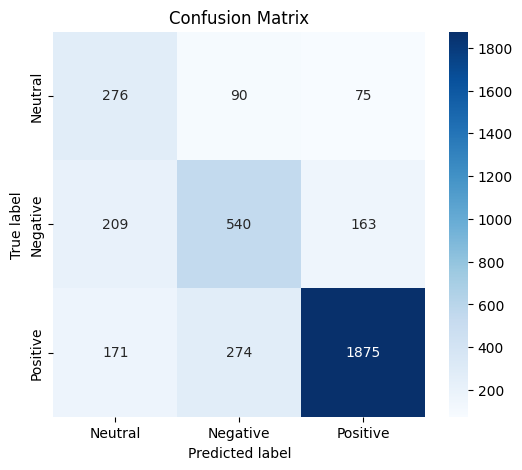

              precision    recall  f1-score   support

     Neutral       0.42      0.63      0.50       441
    Negative       0.60      0.59      0.59       912
    Positive       0.89      0.81      0.85      2320

    accuracy                           0.73      3673
   macro avg       0.64      0.68      0.65      3673
weighted avg       0.76      0.73      0.74      3673



In [39]:
y_predict=logistic.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score

print("Accuracy",accuracy_score(y_test, y_predict))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['Neutral', 'Negative', 'Positive']))

Sans smote c'est un peu moins bien

Naive_bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

Accuracy 0.6964334331609039


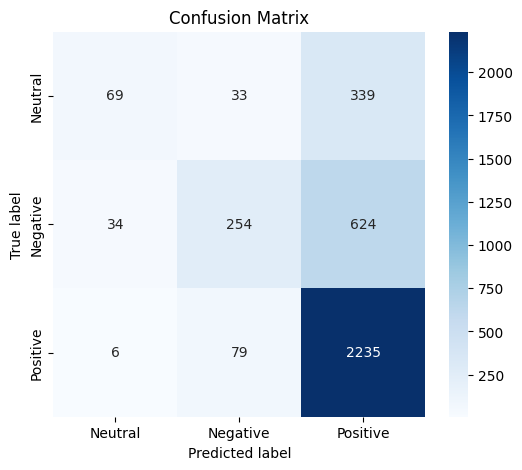

              precision    recall  f1-score   support

     Neutral       0.63      0.16      0.25       441
    Negative       0.69      0.28      0.40       912
    Positive       0.70      0.96      0.81      2320

    accuracy                           0.70      3673
   macro avg       0.68      0.47      0.49      3673
weighted avg       0.69      0.70      0.64      3673



In [40]:
y_predict=nb.predict(X_test_tfidf)
from sklearn.metrics import accuracy_score
print("Accuracy",accuracy_score(y_test, y_predict))

from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['Neutral', 'Negative', 'Positive']))


Random Forest

In [ ]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

In [17]:
type(X_train_tfidf)

scipy.sparse._csr.csr_matrix

In [18]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)



Accuracy 0.732643615573101


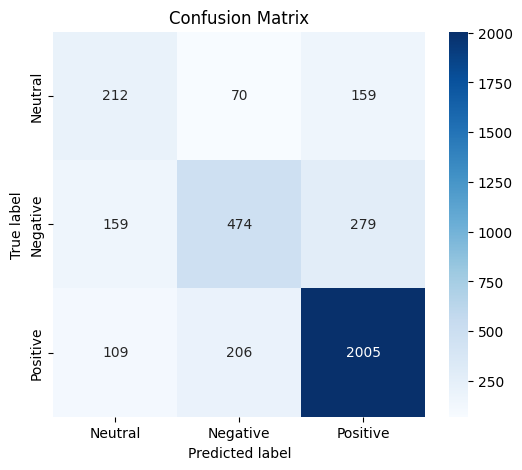

              precision    recall  f1-score   support

     Neutral       0.44      0.48      0.46       441
    Negative       0.63      0.52      0.57       912
    Positive       0.82      0.86      0.84      2320

    accuracy                           0.73      3673
   macro avg       0.63      0.62      0.62      3673
weighted avg       0.73      0.73      0.73      3673



In [41]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
randomforest.fit(X_train_smote, y_train_smote)
y_predict=randomforest.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score
print("Accuracy",accuracy_score(y_test, y_predict))

from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['Neutral', 'Negative', 'Positive']))

Sans Smote

In [42]:
randomforest.fit(X_train_tfidf, y_train)
y_predict=randomforest.predict(X_test_tfidf)
print("Accuracy",accuracy_score(y_test, y_predict))
confusion_matrix(y_test, y_predict)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict, target_names=['Neutral', 'Negative', 'Positive']))

Accuracy 0.7389055268173156
              precision    recall  f1-score   support

     Neutral       0.54      0.28      0.37       441
    Negative       0.63      0.56      0.59       912
    Positive       0.79      0.90      0.84      2320

    accuracy                           0.74      3673
   macro avg       0.65      0.58      0.60      3673
weighted avg       0.72      0.74      0.72      3673



Xgboost

c:\Users\arist\Anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:12:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7446229240402941
              precision    recall  f1-score   support

     Neutral       0.64      0.28      0.39       441
    Negative       0.59      0.64      0.61       912
    Positive       0.81      0.88      0.84      2320

    accuracy                           0.74      3673
   macro avg       0.68      0.60      0.62      3673
weighted avg       0.74      0.74      0.73      3673



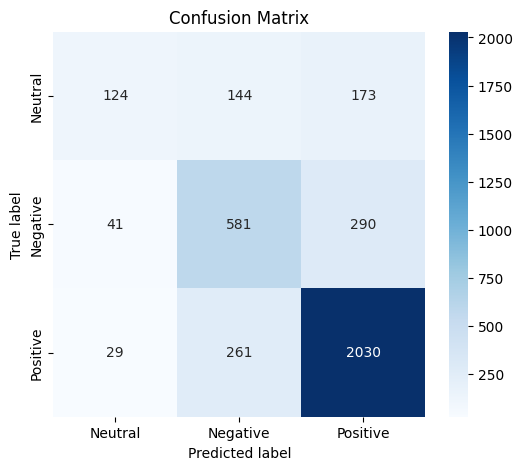

In [52]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Entraînement du modèle XGBoost
xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb.fit(X_train_tfidf, y_train)

# Prédictions
y_pred = xgb.predict(X_test_tfidf)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Transformer Distil bert

In [111]:
def clean_text_bert(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # supprimer URLs
    text = re.sub(r'@\w+', '', text)                     # supprimer mentions
    text = re.sub(r'#', '', text)                        # retirer # mais garder le mot
    text = emoji.demojize(text)                          # transformer emojis en texte (par ex. 😊 -> :smile:)
    text = re.sub(r'[^\w\s:]', '', text)                 # retirer ponctuation mais garder les mots des emojis
    text = re.sub(r'\s+', ' ', text).strip()            # supprimer espaces multiples
    return text

In [150]:
df = pd.read_csv("C:/Users/arist/Downloads/archive/YoutubeCommentsDataSet.csv")  

df.head()

,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [151]:
df = df.dropna()  # supprime les lignes vides
df = df.drop_duplicates()  # supprime les doublons
df['Comment'] = df['Comment'].str.strip()  # retire les espaces en début/fin

In [152]:
label_map = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
df['label'] = df['Sentiment'].map(label_map)

In [153]:
df = df.rename(columns={'Comment': 'text'})

# Garder uniquement les colonnes utiles
df = df[['text', 'label']]

In [154]:
df.head()

,text,label
0,lets not forget that apple pay in 2014 require...,1
1,here in nz 50 of retailers don’t even have con...,0
2,i will forever acknowledge this channel with t...,2
3,whenever i go to a place that doesn’t take app...,0
4,apple pay is so convenient secure and easy to ...,2


In [161]:
df.shape

(17874, 2)

In [166]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

# Split train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Conversion en dataset HuggingFace
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 1. Sous-échantillonner le dataset pour aller vite
train_dataset = train_dataset.shuffle(seed=42).select(range(7000))
test_dataset = test_dataset.shuffle(seed=42).select(range(1000))

# ---------------------------
# 2. Tokenization
# ---------------------------
model_checkpoint = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_fn(example):
     return tokenizer(
        example["text"], 
        truncation=True,         # tronque les textes trop longs
        max_length=512,          # longueur maximale pour BERT
        padding="max_length"     # optionnel : pad les textes plus courts
    )

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

# ---------------------------
# 3. Préparation du modèle
# ---------------------------
num_labels = len(label_map)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# ---------------------------
# 4. Métriques
# ---------------------------
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}

# ---------------------------
# 5. Entraînement
# ---------------------------
training_args = TrainingArguments(
    output_dir="./sentiment_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# ---------------------------
# 6. Sauvegarde du modèle
# ---------------------------
trainer.save_model("./sentiment_model")
tokenizer.save_pretrained("./sentiment_model")

print("✅ Fine-tuning terminé et modèle sauvegardé dans ./sentiment_model")



Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\arist\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\arist\AppData\Local\Temp\ipykernel_14800\2414886951.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.830676,0.662000,0.572200
2,0.897400,0.794122,0.678000,0.599346


✅ Fine-tuning terminé et modèle sauvegardé dans ./sentiment_model


In [168]:
# Évaluation sur le jeu de test
results = trainer.evaluate(test_dataset)
print(results)


{'eval_loss': 0.7941219210624695, 'eval_accuracy': 0.678, 'eval_f1': 0.5993461864025889, 'eval_runtime': 26.6798, 'eval_samples_per_second': 37.482, 'eval_steps_per_second': 2.361, 'epoch': 2.0}


LSTM

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Paramètres
max_words = 5000
max_len = 100

# Tokenisation
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Encodage des labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Modèle LSTM
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement
history = model.fit(X_train_pad, y_train_cat, epochs=7, batch_size=64, validation_data=(X_test_pad, y_test_cat))

# Évaluation
score = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print("Test accuracy:", score[1])

Epoch 1/7


C:\Users\arist\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


230/230 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.6481 - loss: 0.8358 - val_accuracy: 0.7340 - val_loss: 0.6005
Epoch 2/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7943 - loss: 0.5143 - val_accuracy: 0.7501 - val_loss: 0.5910
Epoch 3/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8472 - loss: 0.3920 - val_accuracy: 0.7457 - val_loss: 0.6201
Epoch 4/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8802 - loss: 0.3230 - val_accuracy: 0.7424 - val_loss: 0.6748
Epoch 5/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.9001 - loss: 0.2724 - val_accuracy: 0.7351 - val_loss: 0.7511
Epoch 6/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9139 - loss: 0.2338 - val_accuracy: 0.7343 - val_loss: 0.8257
Epoch 7/7
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.9299 - loss: 0.1951 - val_accuracy: 0.7321 - val_loss: 0.8675
Test accuracy: 0.7320991158485413


We can see that at epoch 2 our accuracy is at our peak and after it goes down. So we will choose to do 3 epochs.

115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

     Neutral       0.50      0.46      0.48       441
    Negative       0.59      0.54      0.56       912
    Positive       0.83      0.88      0.85      2320

    accuracy                           0.74      3673
   macro avg       0.64      0.63      0.63      3673
weighted avg       0.73      0.74      0.74      3673



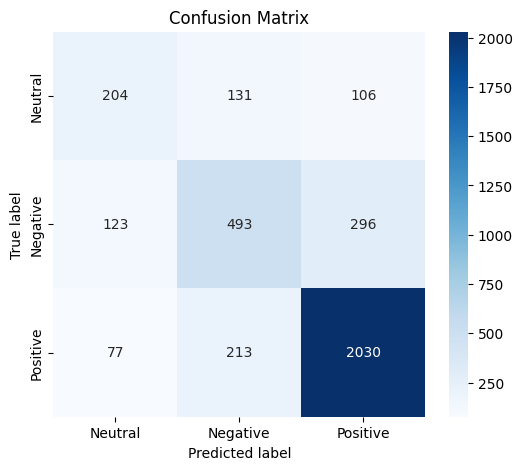

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prédictions sur le jeu de test
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

# Classification report
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Negative', 'Positive'], yticklabels=['Neutral', 'Negative', 'Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()